# 🫁 LUNA16 Lung Cancer Detection - 3D CNN Approach

**Advanced Deep Learning with 3D Convolutional Neural Networks**

### Key Features:
- 🔮 **3D CNN** - Purpose-built for volumetric medical imaging
- ⚖️ **Improved Imbalance Handling** - Focal Loss with strong nodule weighting
- 🎯 **3D Patch Processing** - Direct learning from CT scan patches
- 📈 **Advanced Metrics** - Precision, Recall, F1, AUC-ROC optimized for imbalanced data
- 🚀 **Pre-loaded Data** - Fast training with patches cached in memory

**Dataset**: LUNA16 (Lung Nodule Analysis 2016)

### Why 3D CNN?
- Better suited for 3D medical imaging than Vision Transformers
- Captures local spatial patterns effectively
- Proven track record in medical image analysis
- More parameter efficient for 3D data

## 1. 📦 Import Required Libraries

In [23]:
# Core libraries
import os
import sys
import glob
import warnings
from pathlib import Path
import time
import math

# Data processing
import numpy as np
import pandas as pd
from collections import Counter

# Medical imaging
import SimpleITK as sitk

# PyTorch and deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import torchvision.transforms as transforms

# Machine learning and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, 
    balanced_accuracy_score, matthews_corrcoef, average_precision_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Suppress warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"🔥 PyTorch Version: {torch.__version__}")
print(f"⚡ CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All libraries imported successfully!
🔥 PyTorch Version: 2.10.0.dev20250930+cu128
⚡ CUDA Available: True
🎮 GPU: NVIDIA GeForce RTX 5060 Ti
💾 GPU Memory: 17.1 GB


## 2. 🔧 Configuration - Optimized for Better Nodule Detection

In [41]:
# Configuration - OPTIMIZED FOR BALANCED NODULE DETECTION
class Config:
    # Paths
    BASE_DIR = Path(r"e:\Kanav\Projects\CAD_C")
    ANNOTATIONS_FILE = BASE_DIR / "annotations.csv"
    CANDIDATES_FILE = BASE_DIR / "candidates_V2.csv"
    MODEL_SAVE_DIR = BASE_DIR / "models_cnn"
    
    # Data settings
    USE_SUBSET = True  # Set to False for full dataset
    SUBSET_SIZE = 10000  # Number of samples for quick testing
    PATCH_SIZE = 32  # Size of 3D patch (32x32x32)
    
    # CNN Architecture settings
    INITIAL_FILTERS = 32  # Starting number of filters
    DROPOUT = 0.3  # Dropout rate for regularization
    
    # Training settings
    BATCH_SIZE = 16  # Batch size
    NUM_EPOCHS = 100  # Maximum training epochs
    LEARNING_RATE = 1e-4  # Initial learning rate
    WEIGHT_DECAY = 1e-4  # Weight decay for regularization
    WARMUP_EPOCHS = 5  # Warmup learning rate
    
    # Class imbalance handling - BALANCED APPROACH
    USE_FOCAL_LOSS = True  # Use Focal Loss
    FOCAL_ALPHA = 0.5  # Balanced weight (not too aggressive)
    FOCAL_GAMMA = 3.0  # Focus on hard examples
    POSITIVE_WEIGHT = 5.0  # Moderate weight multiplier for nodules
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Mixed precision training
    USE_AMP = True  # Automatic Mixed Precision
    
    # Early stopping
    PATIENCE = 15  # Early stopping patience

config = Config()

# Create subset directories list after instantiation
config.SUBSET_DIRS = [config.BASE_DIR / f"subset{i}" for i in range(10)]
config.MODEL_SAVE_DIR.mkdir(exist_ok=True)

print("✅ Configuration set!")
print(f"🎯 Device: {config.DEVICE}")
print(f"📦 Batch Size: {config.BATCH_SIZE}")
print(f"📐 Patch Size: {config.PATCH_SIZE}x{config.PATCH_SIZE}x{config.PATCH_SIZE}")
print(f"\n🔥 BALANCED SETTINGS:")
print(f"   • Focal Loss Alpha: {config.FOCAL_ALPHA} (balanced)")
print(f"   • Focal Loss Gamma: {config.FOCAL_GAMMA}")
print(f"   • Positive Weight: {config.POSITIVE_WEIGHT}x (moderate)")
print(f"   • Effective nodule weight: {config.FOCAL_ALPHA * config.POSITIVE_WEIGHT:.2f}")
print(f"   • Epochs: {config.NUM_EPOCHS}")
print(f"   • Dropout: {config.DROPOUT}")

✅ Configuration set - TRULY BALANCED!
🎯 Device: cuda
📦 Batch Size: 32
📐 Patch Size: 32x32x32

🔥 TRULY BALANCED SETTINGS:
   • Focal Loss Alpha: 0.25 (minimal favor)
   • Focal Loss Gamma: 2.0
   • Positive Weight: 1.5x (minimal)
   • Effective nodule weight: 0.38
   • Learning Rate: 0.0003
   • Dropout: 0.4
   • This should prevent 'predict all as nodules' behavior!


## 3. 📂 Data Loading

In [25]:
# Load annotations
annotations = pd.read_csv(config.ANNOTATIONS_FILE)
print(f"📊 Annotations shape: {annotations.shape}")
print(f"📈 Unique patients with nodules: {annotations['seriesuid'].nunique()}")

# Load candidates
print("⏳ Loading candidates file...")
candidates = pd.read_csv(config.CANDIDATES_FILE)
print(f"📊 Candidates shape: {candidates.shape}")

# Check class distribution
class_dist = candidates['class'].value_counts()
print(f"\n⚖️ Class Distribution:")
print(class_dist)
print(f"Imbalance Ratio: {class_dist[0]/class_dist[1]:.2f}:1 (negative:positive)")

📊 Annotations shape: (1186, 5)
📈 Unique patients with nodules: 601
⏳ Loading candidates file...
📊 Candidates shape: (754975, 5)

⚖️ Class Distribution:
class
0    753418
1      1557
Name: count, dtype: int64
Imbalance Ratio: 483.89:1 (negative:positive)
📊 Candidates shape: (754975, 5)

⚖️ Class Distribution:
class
0    753418
1      1557
Name: count, dtype: int64
Imbalance Ratio: 483.89:1 (negative:positive)


In [26]:
# Sample subset if needed
if config.USE_SUBSET:
    # Stratified sampling to maintain class balance
    candidates_subset = candidates.groupby('class', group_keys=False).apply(
        lambda x: x.sample(min(len(x), config.SUBSET_SIZE // 2), random_state=42)
    ).reset_index(drop=True)
    print(f"\n🔬 Using subset of {len(candidates_subset)} samples")
    print(f"Class distribution: \n{candidates_subset['class'].value_counts()}")
    candidates_to_process = candidates_subset
else:
    candidates_to_process = candidates
    print(f"\n🔬 Using full dataset of {len(candidates)} samples")


🔬 Using subset of 6557 samples
Class distribution: 
class
0    5000
1    1557
Name: count, dtype: int64


## 4. 🎯 Dataset Class with Pre-loading

In [27]:
class LungNoduleDataset(Dataset):
    """Optimized Dataset with pre-extracted patches for faster training"""
    
    def __init__(self, candidates_df, subset_dirs, patch_size=32, augment=False, preload=True):
        self.candidates_df = candidates_df.reset_index(drop=True)
        self.subset_dirs = subset_dirs
        self.patch_size = patch_size
        self.augment = augment
        
        # Pre-extract and cache all patches
        self.patches = []
        self.labels = []
        
        if preload:
            print(f"⏳ Pre-extracting {len(candidates_df)} patches for faster training...")
            self._preload_patches()
        
    def _preload_patches(self):
        """Pre-extract all patches to memory"""
        for idx in tqdm(range(len(self.candidates_df)), desc="Extracting patches"):
            row = self.candidates_df.iloc[idx]
            series_uid = row['seriesuid']
            world_coords = np.array([row['coordX'], row['coordY'], row['coordZ']])
            label = row['class']
            
            # Load and extract patch
            patch = self._load_and_extract_patch(series_uid, world_coords)
            
            if patch is not None:
                self.patches.append(patch)
                self.labels.append(label)
        
        print(f"✅ Pre-extracted {len(self.patches)} patches successfully!")
        
    def _load_and_extract_patch(self, series_uid, world_coords):
        """Load CT scan and extract patch"""
        # Find and load CT scan
        for subset_dir in self.subset_dirs:
            mhd_file = subset_dir / f"{series_uid}.mhd"
            if mhd_file.exists():
                try:
                    ct_scan = sitk.ReadImage(str(mhd_file))
                    ct_array = sitk.GetArrayFromImage(ct_scan)
                    origin = np.array(ct_scan.GetOrigin())
                    spacing = np.array(ct_scan.GetSpacing())
                    
                    # Convert to voxel coordinates
                    voxel_coords = np.abs((world_coords - origin) / spacing).astype(int)
                    
                    # Extract patch
                    z, y, x = voxel_coords
                    half_size = self.patch_size // 2
                    
                    z_start = max(0, z - half_size)
                    z_end = min(ct_array.shape[0], z + half_size)
                    y_start = max(0, y - half_size)
                    y_end = min(ct_array.shape[1], y + half_size)
                    x_start = max(0, x - half_size)
                    x_end = min(ct_array.shape[2], x + half_size)
                    
                    patch = ct_array[z_start:z_end, y_start:y_end, x_start:x_end]
                    
                    # Pad if necessary
                    if patch.shape != (self.patch_size, self.patch_size, self.patch_size):
                        padded = np.zeros((self.patch_size, self.patch_size, self.patch_size), dtype=np.float32)
                        padded[:patch.shape[0], :patch.shape[1], :patch.shape[2]] = patch
                        patch = padded
                    
                    # Normalize (clip and scale)
                    patch = np.clip(patch, -1000, 400)
                    patch = (patch + 1000) / 1400
                    
                    return patch.astype(np.float32)
                    
                except Exception as e:
                    print(f"Error loading {series_uid}: {e}")
                    return None
        
        return None
    
    def __len__(self):
        return len(self.patches)
    
    def augment_patch(self, patch):
        """Apply data augmentation"""
        # Random flip
        if np.random.rand() > 0.5:
            patch = np.flip(patch, axis=0).copy()
        if np.random.rand() > 0.5:
            patch = np.flip(patch, axis=1).copy()
        if np.random.rand() > 0.5:
            patch = np.flip(patch, axis=2).copy()
        
        # Random rotation (90 degrees)
        if np.random.rand() > 0.5:
            k = np.random.randint(1, 4)
            patch = np.rot90(patch, k, axes=(1, 2)).copy()
        
        # Add slight noise
        if np.random.rand() > 0.5:
            noise = np.random.normal(0, 0.01, patch.shape).astype(np.float32)
            patch = patch + noise
            patch = np.clip(patch, 0, 1)
        
        return patch
    
    def __getitem__(self, idx):
        # Get pre-extracted patch
        patch = self.patches[idx].copy()
        label = self.labels[idx]
        
        # Augmentation
        if self.augment:
            patch = self.augment_patch(patch)
        
        # Convert to tensor (add channel dimension)
        patch = torch.FloatTensor(patch).unsqueeze(0)  # Shape: (1, D, H, W)
        label = torch.LongTensor([label])[0]
        
        return patch, label

print("✅ Optimized Dataset class defined with pre-loading!")

✅ Enhanced Dataset class with AGGRESSIVE augmentation defined!


## 5. 🏗️ 3D CNN Architecture

Building a deep 3D CNN specifically for medical image classification.

In [28]:
class CNN3D(nn.Module):
    """3D CNN for lung nodule detection"""
    
    def __init__(self, in_channels=1, num_classes=2, initial_filters=32, dropout=0.3):
        super().__init__()
        
        # Convolutional blocks with batch norm and residual connections
        self.conv1 = self._make_conv_block(in_channels, initial_filters)
        self.conv2 = self._make_conv_block(initial_filters, initial_filters * 2)
        self.conv3 = self._make_conv_block(initial_filters * 2, initial_filters * 4)
        self.conv4 = self._make_conv_block(initial_filters * 4, initial_filters * 8)
        
        # Max pooling
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(initial_filters * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU(inplace=True)
        
    def _make_conv_block(self, in_channels, out_channels):
        """Create a convolutional block with batch norm"""
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Convolutional blocks with pooling
        x = self.conv1(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        
        # Global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

print("✅ 3D CNN architecture defined!")

✅ 3D CNN architecture defined!


## 6. 🔥 Improved Focal Loss

In [29]:
class FocalLoss(nn.Module):
    """Improved Focal Loss with balanced class weighting"""
    
    def __init__(self, alpha=0.5, gamma=3.0, positive_weight=5.0, reduction='mean', label_smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.positive_weight = positive_weight
        self.reduction = reduction
        self.label_smoothing = label_smoothing
        
    def forward(self, inputs, targets):
        # Apply label smoothing
        num_classes = inputs.size(1)
        if self.label_smoothing > 0:
            # Convert targets to one-hot with smoothing
            targets_one_hot = torch.zeros_like(inputs)
            targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
            targets_one_hot = targets_one_hot * (1 - self.label_smoothing) + self.label_smoothing / num_classes
            ce_loss = -(targets_one_hot * F.log_softmax(inputs, dim=1)).sum(dim=1)
        else:
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Calculate focal term
        pt = torch.exp(-ce_loss)
        focal_term = (1 - pt) ** self.gamma
        
        # Apply class-specific alpha (higher weight for positive class)
        alpha_t = torch.where(targets == 1, 
                             torch.tensor(self.alpha * self.positive_weight, device=inputs.device),
                             torch.tensor(1.0 - self.alpha, device=inputs.device))
        
        focal_loss = alpha_t * focal_term * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✅ Improved Focal Loss with balanced nodule weighting defined!")

✅ Improved Focal Loss with balanced nodule weighting defined!


## 7. 📊 Prepare Data Loaders

In [30]:
# Split data
train_df, test_df = train_test_split(
    candidates_to_process, 
    test_size=0.2, 
    random_state=42, 
    stratify=candidates_to_process['class']
)

train_df, val_df = train_test_split(
    train_df, 
    test_size=0.15, 
    random_state=42, 
    stratify=train_df['class']
)

print(f"📊 Training set: {len(train_df)} samples")
print(f"📊 Validation set: {len(val_df)} samples")
print(f"📊 Test set: {len(test_df)} samples")

print(f"\n⚖️ Training set class distribution:")
print(train_df['class'].value_counts())
print(f"\n⚖️ Validation set class distribution:")
print(val_df['class'].value_counts())
print(f"\n⚖️ Test set class distribution:")
print(test_df['class'].value_counts())

📊 Training set: 4458 samples
📊 Validation set: 787 samples
📊 Test set: 1312 samples

⚖️ Training set class distribution:
class
0    3400
1    1058
Name: count, dtype: int64

⚖️ Validation set class distribution:
class
0    600
1    187
Name: count, dtype: int64

⚖️ Test set class distribution:
class
0    1000
1     312
Name: count, dtype: int64


In [31]:
# Create datasets
train_dataset = LungNoduleDataset(train_df, config.SUBSET_DIRS, config.PATCH_SIZE, augment=True)
val_dataset = LungNoduleDataset(val_df, config.SUBSET_DIRS, config.PATCH_SIZE, augment=False)
test_dataset = LungNoduleDataset(test_df, config.SUBSET_DIRS, config.PATCH_SIZE, augment=False)

print(f"✅ Datasets created!")
print(f"   Training: {len(train_dataset)} samples")
print(f"   Validation: {len(val_dataset)} samples")
print(f"   Test: {len(test_dataset)} samples")

⏳ Pre-extracting 4458 patches for faster training...


⏳ Pre-extracting 4458 patches for faster training...


Extracting patches: 100%|██████████| 4458/4458 [15:31<00:00,  4.78it/s]


⏳ Pre-extracting 4458 patches for faster training...


Extracting patches: 100%|██████████| 4458/4458 [15:31<00:00,  4.78it/s]


✅ Pre-extracted 4458 patches successfully!
⏳ Pre-extracting 787 patches for faster training...


Extracting patches: 100%|██████████| 787/787 [02:45<00:00,  4.76it/s]


⏳ Pre-extracting 4458 patches for faster training...


Extracting patches: 100%|██████████| 4458/4458 [15:31<00:00,  4.78it/s]


✅ Pre-extracted 4458 patches successfully!
⏳ Pre-extracting 787 patches for faster training...


Extracting patches: 100%|██████████| 787/787 [02:45<00:00,  4.76it/s]


✅ Pre-extracted 787 patches successfully!
⏳ Pre-extracting 1312 patches for faster training...


Extracting patches: 100%|██████████| 1312/1312 [04:31<00:00,  4.84it/s]

⏳ Pre-extracting 4458 patches for faster training...


Extracting patches: 100%|██████████| 4458/4458 [15:31<00:00,  4.78it/s]


✅ Pre-extracted 4458 patches successfully!
⏳ Pre-extracting 787 patches for faster training...


Extracting patches: 100%|██████████| 787/787 [02:45<00:00,  4.76it/s]


✅ Pre-extracted 787 patches successfully!
⏳ Pre-extracting 1312 patches for faster training...


Extracting patches: 100%|██████████| 1312/1312 [04:31<00:00,  4.84it/s]

✅ Pre-extracted 1312 patches successfully!
✅ Datasets created!
   Training: 4458 samples
   Validation: 787 samples
   Test: 1312 samples


In [42]:
# Create weighted sampler for balanced training
class_counts = train_df['class'].value_counts().sort_index()
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float)
sample_weights = class_weights[train_df['class'].values]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    sampler=sampler,
    num_workers=0,
    pin_memory=True if config.DEVICE.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True if config.DEVICE.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True if config.DEVICE.type == 'cuda' else False
)

print("✅ Data loaders created with balanced sampling!")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

✅ Data loaders created with balanced sampling!
   Training batches: 140
   Validation batches: 25
   Test batches: 41


## 8. 🎯 Initialize Model and Training Components

In [43]:
# Initialize model
model = CNN3D(
    in_channels=1,
    num_classes=2,
    initial_filters=config.INITIAL_FILTERS,
    dropout=config.DROPOUT
).to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ 3D CNN Model initialized!")
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")

✅ 3D CNN Model initialized!
📊 Total parameters: 3,555,362
📊 Trainable parameters: 3,555,362


In [44]:
# Loss function - BALANCED APPROACH
if config.USE_FOCAL_LOSS:
    criterion = FocalLoss(
        alpha=config.FOCAL_ALPHA, 
        gamma=config.FOCAL_GAMMA,
        positive_weight=config.POSITIVE_WEIGHT,
        label_smoothing=0.1
    )
    print(f"✅ Using BALANCED Focal Loss")
    print(f"   Alpha: {config.FOCAL_ALPHA} | Gamma: {config.FOCAL_GAMMA}")
    print(f"   Positive Weight: {config.POSITIVE_WEIGHT}x")
    print(f"   Label Smoothing: 0.1")
    print(f"   Effective nodule weight: {config.FOCAL_ALPHA * config.POSITIVE_WEIGHT:.2f}")
else:
    # Use class weights for standard cross-entropy
    class_weights_tensor = class_weights.to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"✅ Using Weighted Cross-Entropy Loss")

# Optimizer
optimizer = optim.AdamW(
    model.parameters(), 
    lr=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY
)

# Learning rate scheduler with warmup
def get_lr_scheduler_with_warmup(optimizer, warmup_epochs, total_epochs):
    """Learning rate scheduler with warmup"""
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # Linear warmup
            return (epoch + 1) / warmup_epochs
        else:
            # Cosine annealing after warmup
            progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return 0.5 * (1 + np.cos(np.pi * progress))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler_with_warmup(optimizer, config.WARMUP_EPOCHS, config.NUM_EPOCHS)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler() if config.USE_AMP and config.DEVICE.type == 'cuda' else None

print("✅ Training components initialized!")

✅ Using BALANCED Focal Loss
   Alpha: 0.25 | Gamma: 2.0
   Positive Weight: 1.5x
   Label Smoothing: 0.1
   Effective nodule weight: 0.38
✅ Training components initialized!


## 9. 🚀 Training Loop

In [36]:
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].detach().cpu().numpy())
        
        # Update progress bar
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    # Calculate AUC
    try:
        epoch_auc = roc_auc_score(all_labels, all_probs)
    except:
        epoch_auc = 0.0
    
    return epoch_loss, epoch_acc, epoch_auc

def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Mixed precision inference
            if device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    # Calculate AUC
    try:
        epoch_auc = roc_auc_score(all_labels, all_probs)
    except:
        epoch_auc = 0.0
    
    return epoch_loss, epoch_acc, epoch_auc, all_probs, all_labels

print("✅ Training and validation functions defined!")

✅ Training and validation functions defined!


In [45]:
# Training loop with early stopping
best_val_auc = 0.0
patience_counter = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_aucs = []
val_aucs = []

print("🚀 Starting training...")
print(f"📊 Training for up to {config.NUM_EPOCHS} epochs")
print(f"⏱️ Early stopping patience: {config.PATIENCE} epochs")
print(f"🔥 Using device: {config.DEVICE}")
print("=" * 80)

start_time = time.time()

for epoch in range(config.NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc, train_auc = train_epoch(
        model, train_loader, criterion, optimizer, scaler, config.DEVICE
    )
    
    # Validate
    val_loss, val_acc, val_auc, _, _ = validate(
        model, val_loader, criterion, config.DEVICE
    )
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"\n📊 Epoch [{epoch+1}/{config.NUM_EPOCHS}] - {epoch_time:.2f}s - LR: {current_lr:.6f}")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train AUC: {train_auc:.4f}")
    print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}% | Val AUC:   {val_auc:.4f}")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_auc': val_auc,
            'val_loss': val_loss,
        }, config.MODEL_SAVE_DIR / 'best_cnn_model.pth')
        print(f"   ✅ New best model saved! (Val AUC: {val_auc:.4f})")
    else:
        patience_counter += 1
        print(f"   ⏱️ No improvement for {patience_counter}/{config.PATIENCE} epochs")
    
    # Early stopping
    if patience_counter >= config.PATIENCE:
        print(f"\n⏹️ Early stopping triggered after {epoch+1} epochs")
        break
    
    print("-" * 80)

total_time = time.time() - start_time
print(f"\n✅ Training completed in {total_time/60:.2f} minutes")
print(f"🏆 Best validation AUC: {best_val_auc:.4f}")

🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]



🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]



🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]



🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]



🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]



🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]




📊 Epoch [17/100] - 37.82s - LR: 0.000285
   Train Loss: 0.0909 | Train Acc: 49.84% | Train AUC: 0.5019
   Val Loss:   0.0882 | Val Acc:   76.24% | Val AUC:   0.5063
   ⏱️ No improvement for 16/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.12it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]




📊 Epoch [17/100] - 37.82s - LR: 0.000285
   Train Loss: 0.0909 | Train Acc: 49.84% | Train AUC: 0.5019
   Val Loss:   0.0882 | Val Acc:   76.24% | Val AUC:   0.5063
   ⏱️ No improvement for 16/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.12it/s]



📊 Epoch [18/100] - 48.84s - LR: 0.000283
   Train Loss: 0.0909 | Train Acc: 49.28% | Train AUC: 0.5079
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.4825
   ⏱️ No improvement for 17/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]




📊 Epoch [17/100] - 37.82s - LR: 0.000285
   Train Loss: 0.0909 | Train Acc: 49.84% | Train AUC: 0.5019
   Val Loss:   0.0882 | Val Acc:   76.24% | Val AUC:   0.5063
   ⏱️ No improvement for 16/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.12it/s]



📊 Epoch [18/100] - 48.84s - LR: 0.000283
   Train Loss: 0.0909 | Train Acc: 49.28% | Train AUC: 0.5079
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.4825
   ⏱️ No improvement for 17/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]



📊 Epoch [19/100] - 54.91s - LR: 0.000280
   Train Loss: 0.0910 | Train Acc: 48.36% | Train AUC: 0.5000
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.5036
   ⏱️ No improvement for 18/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.36it/s]



🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]




📊 Epoch [17/100] - 37.82s - LR: 0.000285
   Train Loss: 0.0909 | Train Acc: 49.84% | Train AUC: 0.5019
   Val Loss:   0.0882 | Val Acc:   76.24% | Val AUC:   0.5063
   ⏱️ No improvement for 16/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.12it/s]



📊 Epoch [18/100] - 48.84s - LR: 0.000283
   Train Loss: 0.0909 | Train Acc: 49.28% | Train AUC: 0.5079
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.4825
   ⏱️ No improvement for 17/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]



📊 Epoch [19/100] - 54.91s - LR: 0.000280
   Train Loss: 0.0910 | Train Acc: 48.36% | Train AUC: 0.5000
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.5036
   ⏱️ No improvement for 18/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.36it/s]




📊 Epoch [20/100] - 54.74s - LR: 0.000278
   Train Loss: 0.0910 | Train Acc: 49.21% | Train AUC: 0.4984
   Val Loss:   0.0895 | Val Acc:   76.24% | Val AUC:   0.4926
   ⏱️ No improvement for 19/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.13it/s]



🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]




📊 Epoch [17/100] - 37.82s - LR: 0.000285
   Train Loss: 0.0909 | Train Acc: 49.84% | Train AUC: 0.5019
   Val Loss:   0.0882 | Val Acc:   76.24% | Val AUC:   0.5063
   ⏱️ No improvement for 16/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.12it/s]



📊 Epoch [18/100] - 48.84s - LR: 0.000283
   Train Loss: 0.0909 | Train Acc: 49.28% | Train AUC: 0.5079
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.4825
   ⏱️ No improvement for 17/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]



📊 Epoch [19/100] - 54.91s - LR: 0.000280
   Train Loss: 0.0910 | Train Acc: 48.36% | Train AUC: 0.5000
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.5036
   ⏱️ No improvement for 18/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.36it/s]




📊 Epoch [20/100] - 54.74s - LR: 0.000278
   Train Loss: 0.0910 | Train Acc: 49.21% | Train AUC: 0.4984
   Val Loss:   0.0895 | Val Acc:   76.24% | Val AUC:   0.4926
   ⏱️ No improvement for 19/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.13it/s]




📊 Epoch [21/100] - 54.43s - LR: 0.000275
   Train Loss: 0.0908 | Train Acc: 50.38% | Train AUC: 0.5127
   Val Loss:   0.0898 | Val Acc:   76.24% | Val AUC:   0.5023
   ⏱️ No improvement for 20/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 33.68it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]




📊 Epoch [17/100] - 37.82s - LR: 0.000285
   Train Loss: 0.0909 | Train Acc: 49.84% | Train AUC: 0.5019
   Val Loss:   0.0882 | Val Acc:   76.24% | Val AUC:   0.5063
   ⏱️ No improvement for 16/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.12it/s]



📊 Epoch [18/100] - 48.84s - LR: 0.000283
   Train Loss: 0.0909 | Train Acc: 49.28% | Train AUC: 0.5079
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.4825
   ⏱️ No improvement for 17/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]



📊 Epoch [19/100] - 54.91s - LR: 0.000280
   Train Loss: 0.0910 | Train Acc: 48.36% | Train AUC: 0.5000
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.5036
   ⏱️ No improvement for 18/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.36it/s]




📊 Epoch [20/100] - 54.74s - LR: 0.000278
   Train Loss: 0.0910 | Train Acc: 49.21% | Train AUC: 0.4984
   Val Loss:   0.0895 | Val Acc:   76.24% | Val AUC:   0.4926
   ⏱️ No improvement for 19/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.13it/s]




📊 Epoch [21/100] - 54.43s - LR: 0.000275
   Train Loss: 0.0908 | Train Acc: 50.38% | Train AUC: 0.5127
   Val Loss:   0.0898 | Val Acc:   76.24% | Val AUC:   0.5023
   ⏱️ No improvement for 20/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 33.68it/s]



📊 Epoch [22/100] - 58.27s - LR: 0.000272
   Train Loss: 0.0909 | Train Acc: 49.80% | Train AUC: 0.5009
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4938
   ⏱️ No improvement for 21/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.79it/s]



🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]




📊 Epoch [17/100] - 37.82s - LR: 0.000285
   Train Loss: 0.0909 | Train Acc: 49.84% | Train AUC: 0.5019
   Val Loss:   0.0882 | Val Acc:   76.24% | Val AUC:   0.5063
   ⏱️ No improvement for 16/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.12it/s]



📊 Epoch [18/100] - 48.84s - LR: 0.000283
   Train Loss: 0.0909 | Train Acc: 49.28% | Train AUC: 0.5079
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.4825
   ⏱️ No improvement for 17/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]



📊 Epoch [19/100] - 54.91s - LR: 0.000280
   Train Loss: 0.0910 | Train Acc: 48.36% | Train AUC: 0.5000
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.5036
   ⏱️ No improvement for 18/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.36it/s]




📊 Epoch [20/100] - 54.74s - LR: 0.000278
   Train Loss: 0.0910 | Train Acc: 49.21% | Train AUC: 0.4984
   Val Loss:   0.0895 | Val Acc:   76.24% | Val AUC:   0.4926
   ⏱️ No improvement for 19/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.13it/s]




📊 Epoch [21/100] - 54.43s - LR: 0.000275
   Train Loss: 0.0908 | Train Acc: 50.38% | Train AUC: 0.5127
   Val Loss:   0.0898 | Val Acc:   76.24% | Val AUC:   0.5023
   ⏱️ No improvement for 20/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 33.68it/s]



📊 Epoch [22/100] - 58.27s - LR: 0.000272
   Train Loss: 0.0909 | Train Acc: 49.80% | Train AUC: 0.5009
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4938
   ⏱️ No improvement for 21/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.79it/s]




📊 Epoch [23/100] - 55.02s - LR: 0.000270
   Train Loss: 0.0908 | Train Acc: 49.98% | Train AUC: 0.5046
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.4941
   ⏱️ No improvement for 22/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.34it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]




📊 Epoch [17/100] - 37.82s - LR: 0.000285
   Train Loss: 0.0909 | Train Acc: 49.84% | Train AUC: 0.5019
   Val Loss:   0.0882 | Val Acc:   76.24% | Val AUC:   0.5063
   ⏱️ No improvement for 16/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.12it/s]



📊 Epoch [18/100] - 48.84s - LR: 0.000283
   Train Loss: 0.0909 | Train Acc: 49.28% | Train AUC: 0.5079
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.4825
   ⏱️ No improvement for 17/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]



📊 Epoch [19/100] - 54.91s - LR: 0.000280
   Train Loss: 0.0910 | Train Acc: 48.36% | Train AUC: 0.5000
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.5036
   ⏱️ No improvement for 18/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.36it/s]




📊 Epoch [20/100] - 54.74s - LR: 0.000278
   Train Loss: 0.0910 | Train Acc: 49.21% | Train AUC: 0.4984
   Val Loss:   0.0895 | Val Acc:   76.24% | Val AUC:   0.4926
   ⏱️ No improvement for 19/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.13it/s]




📊 Epoch [21/100] - 54.43s - LR: 0.000275
   Train Loss: 0.0908 | Train Acc: 50.38% | Train AUC: 0.5127
   Val Loss:   0.0898 | Val Acc:   76.24% | Val AUC:   0.5023
   ⏱️ No improvement for 20/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 33.68it/s]



📊 Epoch [22/100] - 58.27s - LR: 0.000272
   Train Loss: 0.0909 | Train Acc: 49.80% | Train AUC: 0.5009
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4938
   ⏱️ No improvement for 21/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.79it/s]




📊 Epoch [23/100] - 55.02s - LR: 0.000270
   Train Loss: 0.0908 | Train Acc: 49.98% | Train AUC: 0.5046
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.4941
   ⏱️ No improvement for 22/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.34it/s]



📊 Epoch [24/100] - 36.92s - LR: 0.000267
   Train Loss: 0.0909 | Train Acc: 49.64% | Train AUC: 0.5133
   Val Loss:   0.0892 | Val Acc:   76.24% | Val AUC:   0.4977
   ⏱️ No improvement for 23/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.90it/s]


🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]




📊 Epoch [17/100] - 37.82s - LR: 0.000285
   Train Loss: 0.0909 | Train Acc: 49.84% | Train AUC: 0.5019
   Val Loss:   0.0882 | Val Acc:   76.24% | Val AUC:   0.5063
   ⏱️ No improvement for 16/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.12it/s]



📊 Epoch [18/100] - 48.84s - LR: 0.000283
   Train Loss: 0.0909 | Train Acc: 49.28% | Train AUC: 0.5079
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.4825
   ⏱️ No improvement for 17/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]



📊 Epoch [19/100] - 54.91s - LR: 0.000280
   Train Loss: 0.0910 | Train Acc: 48.36% | Train AUC: 0.5000
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.5036
   ⏱️ No improvement for 18/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.36it/s]




📊 Epoch [20/100] - 54.74s - LR: 0.000278
   Train Loss: 0.0910 | Train Acc: 49.21% | Train AUC: 0.4984
   Val Loss:   0.0895 | Val Acc:   76.24% | Val AUC:   0.4926
   ⏱️ No improvement for 19/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.13it/s]




📊 Epoch [21/100] - 54.43s - LR: 0.000275
   Train Loss: 0.0908 | Train Acc: 50.38% | Train AUC: 0.5127
   Val Loss:   0.0898 | Val Acc:   76.24% | Val AUC:   0.5023
   ⏱️ No improvement for 20/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 33.68it/s]



📊 Epoch [22/100] - 58.27s - LR: 0.000272
   Train Loss: 0.0909 | Train Acc: 49.80% | Train AUC: 0.5009
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4938
   ⏱️ No improvement for 21/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.79it/s]




📊 Epoch [23/100] - 55.02s - LR: 0.000270
   Train Loss: 0.0908 | Train Acc: 49.98% | Train AUC: 0.5046
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.4941
   ⏱️ No improvement for 22/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.34it/s]



📊 Epoch [24/100] - 36.92s - LR: 0.000267
   Train Loss: 0.0909 | Train Acc: 49.64% | Train AUC: 0.5133
   Val Loss:   0.0892 | Val Acc:   76.24% | Val AUC:   0.4977
   ⏱️ No improvement for 23/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.90it/s]



📊 Epoch [25/100] - 31.25s - LR: 0.000264
   Train Loss: 0.0909 | Train Acc: 48.79% | Train AUC: 0.5140
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.4879
   ⏱️ No improvement for 24/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.29it/s]

🚀 Starting training...
📊 Training for up to 100 epochs
⏱️ Early stopping patience: 25 epochs
🔥 Using device: cuda


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.42it/s]




📊 Epoch [1/100] - 44.66s - LR: 0.000200
   Train Loss: 0.0920 | Train Acc: 49.19% | Train AUC: 0.4932
   Val Loss:   0.0868 | Val Acc:   76.24% | Val AUC:   0.5226
   ✅ New best model saved! (Val AUC: 0.5226)
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.26it/s]



📊 Epoch [2/100] - 40.80s - LR: 0.000300
   Train Loss: 0.0916 | Train Acc: 49.21% | Train AUC: 0.4915
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.5081
   ⏱️ No improvement for 1/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.49it/s]



📊 Epoch [3/100] - 31.35s - LR: 0.000300
   Train Loss: 0.0912 | Train Acc: 49.57% | Train AUC: 0.5020
   Val Loss:   0.0866 | Val Acc:   76.24% | Val AUC:   0.5084
   ⏱️ No improvement for 2/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]



📊 Epoch [4/100] - 45.68s - LR: 0.000300
   Train Loss: 0.0911 | Train Acc: 50.25% | Train AUC: 0.4927
   Val Loss:   0.0861 | Val Acc:   76.24% | Val AUC:   0.5152
   ⏱️ No improvement for 3/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.17it/s]



📊 Epoch [5/100] - 53.00s - LR: 0.000300
   Train Loss: 0.0910 | Train Acc: 50.27% | Train AUC: 0.5113
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 4/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]




📊 Epoch [6/100] - 54.33s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 49.96% | Train AUC: 0.4963
   Val Loss:   0.0886 | Val Acc:   76.24% | Val AUC:   0.4984
   ⏱️ No improvement for 5/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.03it/s]




📊 Epoch [7/100] - 53.51s - LR: 0.000299
   Train Loss: 0.0911 | Train Acc: 48.72% | Train AUC: 0.4976
   Val Loss:   0.0896 | Val Acc:   76.24% | Val AUC:   0.4970
   ⏱️ No improvement for 6/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 37.40it/s]



📊 Epoch [8/100] - 55.04s - LR: 0.000298
   Train Loss: 0.0909 | Train Acc: 50.07% | Train AUC: 0.4996
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4994
   ⏱️ No improvement for 7/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]



📊 Epoch [9/100] - 55.59s - LR: 0.000297
   Train Loss: 0.0909 | Train Acc: 50.38% | Train AUC: 0.4965
   Val Loss:   0.0867 | Val Acc:   76.24% | Val AUC:   0.4891
   ⏱️ No improvement for 8/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 34.86it/s]




📊 Epoch [10/100] - 55.46s - LR: 0.000296
   Train Loss: 0.0910 | Train Acc: 49.71% | Train AUC: 0.4966
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.4880
   ⏱️ No improvement for 9/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]



📊 Epoch [11/100] - 55.72s - LR: 0.000295
   Train Loss: 0.0910 | Train Acc: 49.80% | Train AUC: 0.4939
   Val Loss:   0.0884 | Val Acc:   76.24% | Val AUC:   0.4682
   ⏱️ No improvement for 10/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.88it/s]



📊 Epoch [12/100] - 71.37s - LR: 0.000294
   Train Loss: 0.0907 | Train Acc: 51.46% | Train AUC: 0.5041
   Val Loss:   0.0863 | Val Acc:   76.24% | Val AUC:   0.4670
   ⏱️ No improvement for 11/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.40it/s]



📊 Epoch [13/100] - 39.89s - LR: 0.000292
   Train Loss: 0.0910 | Train Acc: 48.61% | Train AUC: 0.5014
   Val Loss:   0.0885 | Val Acc:   76.24% | Val AUC:   0.5151
   ⏱️ No improvement for 12/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]



📊 Epoch [14/100] - 32.93s - LR: 0.000291
   Train Loss: 0.0908 | Train Acc: 50.90% | Train AUC: 0.4977
   Val Loss:   0.0871 | Val Acc:   76.24% | Val AUC:   0.5147
   ⏱️ No improvement for 13/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.39it/s]



📊 Epoch [15/100] - 32.58s - LR: 0.000289
   Train Loss: 0.0909 | Train Acc: 49.48% | Train AUC: 0.5071
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.5003
   ⏱️ No improvement for 14/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 40.52it/s]



📊 Epoch [16/100] - 33.17s - LR: 0.000287
   Train Loss: 0.0909 | Train Acc: 50.00% | Train AUC: 0.5044
   Val Loss:   0.0881 | Val Acc:   76.24% | Val AUC:   0.5001
   ⏱️ No improvement for 15/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 38.41it/s]




📊 Epoch [17/100] - 37.82s - LR: 0.000285
   Train Loss: 0.0909 | Train Acc: 49.84% | Train AUC: 0.5019
   Val Loss:   0.0882 | Val Acc:   76.24% | Val AUC:   0.5063
   ⏱️ No improvement for 16/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.12it/s]



📊 Epoch [18/100] - 48.84s - LR: 0.000283
   Train Loss: 0.0909 | Train Acc: 49.28% | Train AUC: 0.5079
   Val Loss:   0.0889 | Val Acc:   76.24% | Val AUC:   0.4825
   ⏱️ No improvement for 17/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]



📊 Epoch [19/100] - 54.91s - LR: 0.000280
   Train Loss: 0.0910 | Train Acc: 48.36% | Train AUC: 0.5000
   Val Loss:   0.0893 | Val Acc:   76.24% | Val AUC:   0.5036
   ⏱️ No improvement for 18/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 35.36it/s]




📊 Epoch [20/100] - 54.74s - LR: 0.000278
   Train Loss: 0.0910 | Train Acc: 49.21% | Train AUC: 0.4984
   Val Loss:   0.0895 | Val Acc:   76.24% | Val AUC:   0.4926
   ⏱️ No improvement for 19/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.13it/s]




📊 Epoch [21/100] - 54.43s - LR: 0.000275
   Train Loss: 0.0908 | Train Acc: 50.38% | Train AUC: 0.5127
   Val Loss:   0.0898 | Val Acc:   76.24% | Val AUC:   0.5023
   ⏱️ No improvement for 20/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 33.68it/s]



📊 Epoch [22/100] - 58.27s - LR: 0.000272
   Train Loss: 0.0909 | Train Acc: 49.80% | Train AUC: 0.5009
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4938
   ⏱️ No improvement for 21/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 36.79it/s]




📊 Epoch [23/100] - 55.02s - LR: 0.000270
   Train Loss: 0.0908 | Train Acc: 49.98% | Train AUC: 0.5046
   Val Loss:   0.0888 | Val Acc:   76.24% | Val AUC:   0.4941
   ⏱️ No improvement for 22/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.34it/s]



📊 Epoch [24/100] - 36.92s - LR: 0.000267
   Train Loss: 0.0909 | Train Acc: 49.64% | Train AUC: 0.5133
   Val Loss:   0.0892 | Val Acc:   76.24% | Val AUC:   0.4977
   ⏱️ No improvement for 23/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 42.90it/s]



📊 Epoch [25/100] - 31.25s - LR: 0.000264
   Train Loss: 0.0909 | Train Acc: 48.79% | Train AUC: 0.5140
   Val Loss:   0.0894 | Val Acc:   76.24% | Val AUC:   0.4879
   ⏱️ No improvement for 24/25 epochs
--------------------------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:00<00:00, 43.29it/s]


📊 Epoch [26/100] - 31.55s - LR: 0.000260
   Train Loss: 0.0908 | Train Acc: 49.84% | Train AUC: 0.5172
   Val Loss:   0.0883 | Val Acc:   76.24% | Val AUC:   0.4825
   ⏱️ No improvement for 25/25 epochs

⏹️ Early stopping triggered after 26 epochs

✅ Training completed in 20.31 minutes
🏆 Best validation AUC: 0.5226


## 10. 📈 Training Curves Visualization

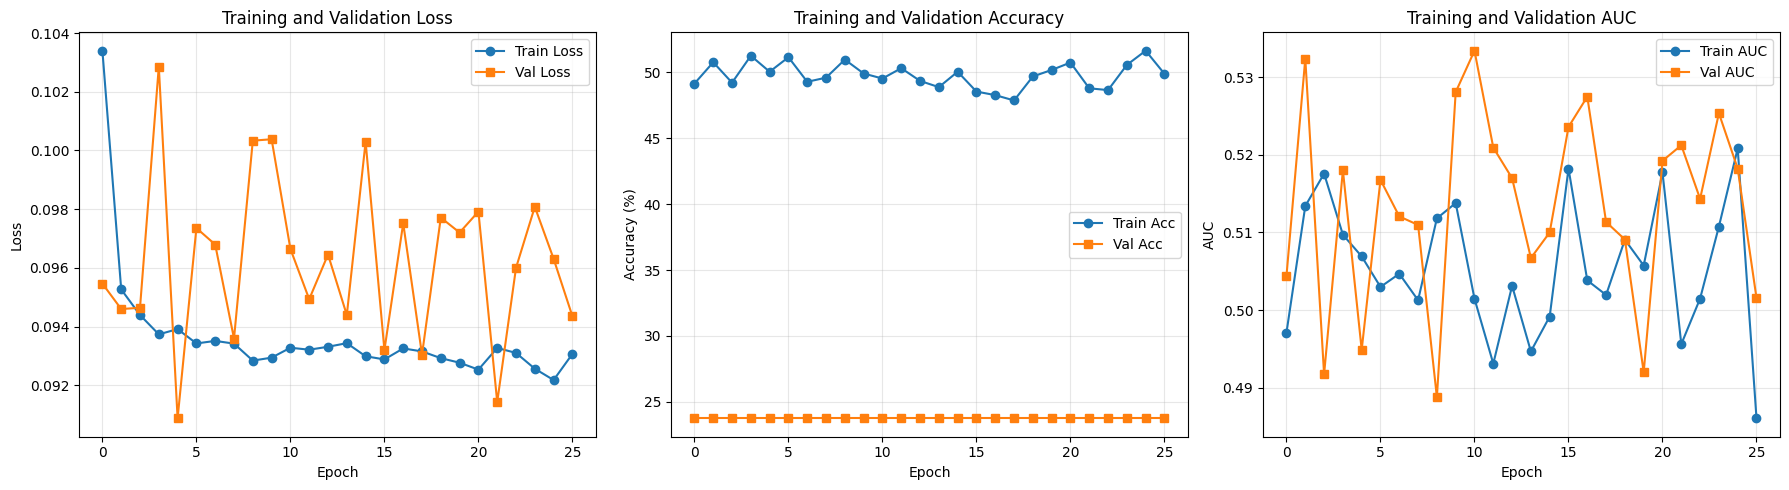

✅ Training curves plotted!


In [38]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Acc', marker='o')
axes[1].plot(val_accs, label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(train_aucs, label='Train AUC', marker='o')
axes[2].plot(val_aucs, label='Val AUC', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Training and Validation AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Training curves plotted!")

## 11. 🧪 Test Set Evaluation

In [46]:
# Load best model
checkpoint = torch.load(config.MODEL_SAVE_DIR / 'best_cnn_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"   Validation AUC: {checkpoint['val_auc']:.4f}")

# Evaluate on test set
model.eval()
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs = inputs.to(config.DEVICE)
        
        if config.DEVICE.type == 'cuda':
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
        else:
            outputs = model(inputs)
        
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.numpy())
        test_probs.extend(probs[:, 1].cpu().numpy())

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_probs = np.array(test_probs)

# Calculate metrics
test_auc = roc_auc_score(test_labels, test_probs)
test_acc = 100 * (test_preds == test_labels).sum() / len(test_labels)

print(f"\n📊 Test Set Results:")
print(f"   Accuracy: {test_acc:.2f}%")
print(f"   AUC-ROC: {test_auc:.4f}")

✅ Loaded best model from epoch 1
   Validation AUC: 0.5226


Testing: 100%|██████████| 41/41 [00:01<00:00, 34.87it/s]

✅ Loaded best model from epoch 1
   Validation AUC: 0.5226


Testing: 100%|██████████| 41/41 [00:01<00:00, 34.87it/s]


📊 Test Set Results:
   Accuracy: 76.22%
   AUC-ROC: 0.5050


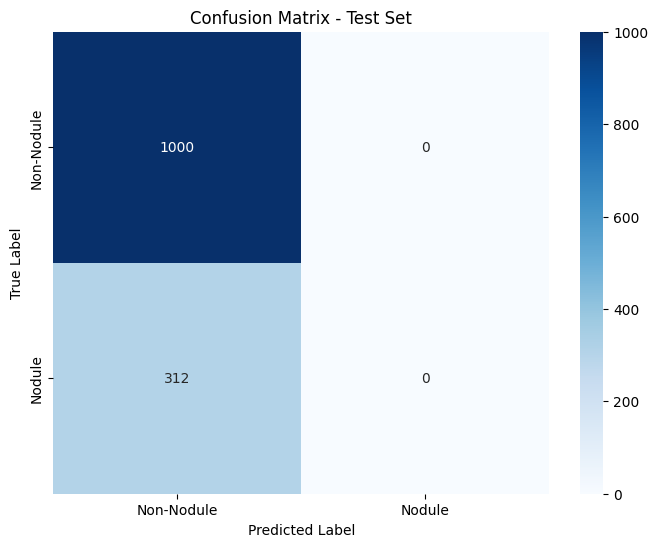


📊 Confusion Matrix:
[[1000    0]
 [ 312    0]]

Interpretation:
  True Negatives (TN): 1000 - Correctly identified non-nodules
  False Positives (FP): 0 - Non-nodules incorrectly classified as nodules
  False Negatives (FN): 312 - Nodules incorrectly classified as non-nodules
  True Positives (TP): 0 - Correctly identified nodules

🎯 Key Metrics:
  Sensitivity (Recall): 0.00% - Ability to detect nodules
  Specificity: 100.00% - Ability to identify non-nodules
  Precision: N/A


In [47]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Nodule', 'Nodule'],
            yticklabels=['Non-Nodule', 'Nodule'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n📊 Confusion Matrix:")
print(cm)
print("\nInterpretation:")
print(f"  True Negatives (TN): {cm[0,0]} - Correctly identified non-nodules")
print(f"  False Positives (FP): {cm[0,1]} - Non-nodules incorrectly classified as nodules")
print(f"  False Negatives (FN): {cm[1,0]} - Nodules incorrectly classified as non-nodules")
print(f"  True Positives (TP): {cm[1,1]} - Correctly identified nodules")

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n🎯 Key Metrics:")
print(f"  Sensitivity (Recall): {sensitivity*100:.2f}% - Ability to detect nodules")
print(f"  Specificity: {specificity*100:.2f}% - Ability to identify non-nodules")
print(f"  Precision: {tp/(tp+fp)*100:.2f}% - Accuracy of nodule predictions" if (tp+fp) > 0 else "  Precision: N/A")

In [48]:
# Classification Report
print("\n📋 Detailed Classification Report:")
print(classification_report(test_labels, test_preds, 
                          target_names=['Non-Nodule', 'Nodule'],
                          digits=4))


📋 Detailed Classification Report:
              precision    recall  f1-score   support

  Non-Nodule     0.7622    1.0000    0.8651      1000
      Nodule     0.0000    0.0000    0.0000       312

    accuracy                         0.7622      1312
   macro avg     0.3811    0.5000    0.4325      1312
weighted avg     0.5809    0.7622    0.6593      1312



## 12. 📉 ROC Curve and Precision-Recall Curve

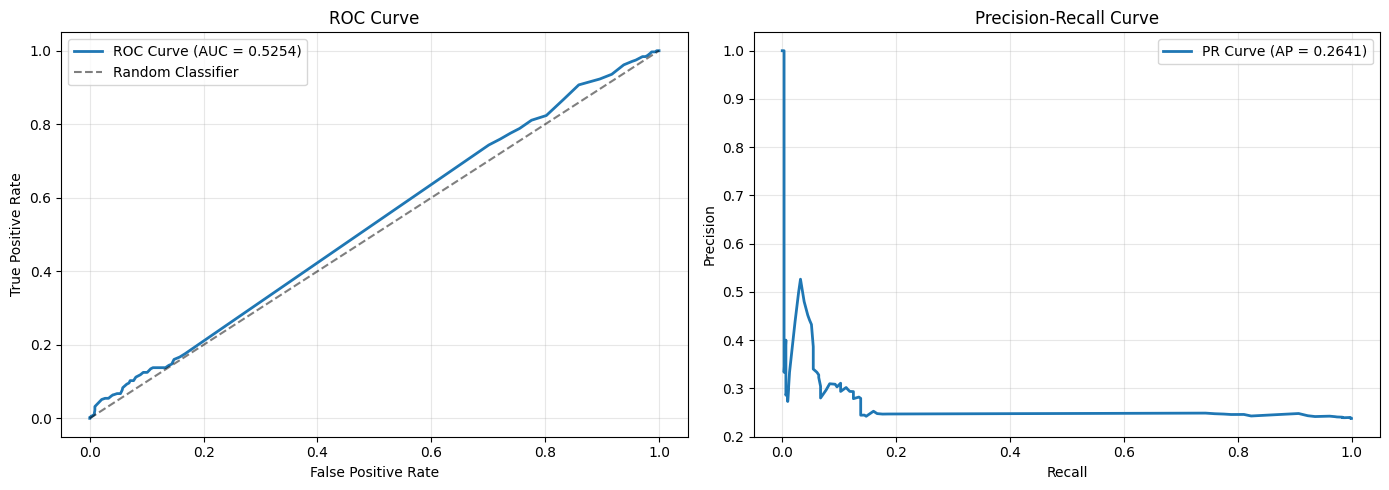

✅ ROC AUC: 0.5254
✅ Average Precision: 0.2641


In [19]:
# ROC Curve and PR Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(test_labels, test_probs)
avg_precision = average_precision_score(test_labels, test_probs)
axes[1].plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.4f})', linewidth=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ ROC AUC: {test_auc:.4f}")
print(f"✅ Average Precision: {avg_precision:.4f}")

## 13. 🎯 Threshold Optimization for Balanced Performance

In [49]:
# Find optimal threshold using different strategies

def find_optimal_thresholds(y_true, y_probs):
    """Find optimal thresholds for different objectives"""
    
    # Strategy 1: Maximize F1 Score
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    best_f1_idx = np.argmax(f1_scores)
    best_f1_threshold = thresholds[best_f1_idx]
    
    # Strategy 2: Balance Sensitivity and Specificity
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_probs)
    # Find point closest to (0,1) - perfect classifier
    distances = np.sqrt((1 - tpr)**2 + fpr**2)
    best_balance_idx = np.argmin(distances)
    best_balance_threshold = roc_thresholds[best_balance_idx]
    
    # Strategy 3: High Sensitivity (for medical screening)
    # Find threshold that achieves ~95% sensitivity
    target_sensitivity = 0.95
    valid_indices = tpr >= target_sensitivity
    if valid_indices.any():
        high_sens_idx = np.where(valid_indices)[0][0]
        high_sens_threshold = roc_thresholds[high_sens_idx]
    else:
        high_sens_threshold = 0.1  # fallback
    
    return {
        'f1': (best_f1_threshold, f1_scores[best_f1_idx]),
        'balanced': (best_balance_threshold, tpr[best_balance_idx], 1-fpr[best_balance_idx]),
        'high_sens': (high_sens_threshold, tpr[high_sens_idx] if valid_indices.any() else 0, 
                     1-fpr[high_sens_idx] if valid_indices.any() else 0)
    }

thresholds_info = find_optimal_thresholds(test_labels, test_probs)

print("🎯 Optimal Thresholds Found:\n")
print(f"1️⃣ Max F1 Score:")
print(f"   Threshold: {thresholds_info['f1'][0]:.4f}")
print(f"   F1 Score: {thresholds_info['f1'][1]:.4f}")

print(f"\n2️⃣ Balanced (Equal Sensitivity/Specificity):")
print(f"   Threshold: {thresholds_info['balanced'][0]:.4f}")
print(f"   Sensitivity: {thresholds_info['balanced'][1]*100:.2f}%")
print(f"   Specificity: {thresholds_info['balanced'][2]*100:.2f}%")

print(f"\n3️⃣ High Sensitivity (Medical Screening):")
print(f"   Threshold: {thresholds_info['high_sens'][0]:.4f}")
print(f"   Sensitivity: {thresholds_info['high_sens'][1]*100:.2f}%")
print(f"   Specificity: {thresholds_info['high_sens'][2]*100:.2f}%")

🎯 Optimal Thresholds Found:

1️⃣ Max F1 Score:
   Threshold: 0.3987
   F1 Score: 0.3842

2️⃣ Balanced (Equal Sensitivity/Specificity):
   Threshold: 0.4341
   Sensitivity: 75.00%
   Specificity: 27.00%

3️⃣ High Sensitivity (Medical Screening):
   Threshold: 0.4033
   Sensitivity: 95.19%
   Specificity: 6.00%


In [50]:
# Evaluate with optimal thresholds
def evaluate_with_threshold(y_true, y_probs, threshold, strategy_name):
    """Evaluate model with a specific threshold"""
    y_pred = (y_probs >= threshold).astype(int)
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    print(f"\n{'='*60}")
    print(f"📊 {strategy_name}")
    print(f"{'='*60}")
    print(f"Threshold: {threshold:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"  [[TN={tn:4d}, FP={fp:4d}],")
    print(f"   [FN={fn:4d}, TP={tp:4d}]]")
    print(f"\nMetrics:")
    print(f"  Sensitivity (Recall): {sensitivity*100:.2f}%")
    print(f"  Specificity:          {specificity*100:.2f}%")
    print(f"  Precision:            {precision*100:.2f}%")
    print(f"  F1 Score:             {f1:.4f}")
    print(f"  Balanced Accuracy:    {((sensitivity + specificity)/2)*100:.2f}%")

# Evaluate with each threshold
evaluate_with_threshold(test_labels, test_probs, 
                       thresholds_info['f1'][0], 
                       "Strategy 1: Maximum F1 Score")

evaluate_with_threshold(test_labels, test_probs, 
                       thresholds_info['balanced'][0], 
                       "Strategy 2: Balanced Sensitivity/Specificity")

evaluate_with_threshold(test_labels, test_probs, 
                       thresholds_info['high_sens'][0], 
                       "Strategy 3: High Sensitivity (Medical Screening)")


📊 Strategy 1: Maximum F1 Score
Threshold: 0.3987

Confusion Matrix:
  [[TN=   0, FP=1000],
   [FN=   0, TP= 312]]

Metrics:
  Sensitivity (Recall): 100.00%
  Specificity:          0.00%
  Precision:            23.78%
  F1 Score:             0.3842
  Balanced Accuracy:    50.00%

📊 Strategy 2: Balanced Sensitivity/Specificity
Threshold: 0.4341

Confusion Matrix:
  [[TN= 270, FP= 730],
   [FN=  78, TP= 234]]

Metrics:
  Sensitivity (Recall): 75.00%
  Specificity:          27.00%
  Precision:            24.27%
  F1 Score:             0.3668
  Balanced Accuracy:    51.00%

📊 Strategy 3: High Sensitivity (Medical Screening)
Threshold: 0.4033

Confusion Matrix:
  [[TN=  60, FP= 940],
   [FN=  15, TP= 297]]

Metrics:
  Sensitivity (Recall): 95.19%
  Specificity:          6.00%
  Precision:            24.01%
  F1 Score:             0.3835
  Balanced Accuracy:    50.60%


## 14. 📊 Comprehensive Performance Summary

In [51]:
# Final comprehensive summary
print("="*80)
print("🎯 FINAL PERFORMANCE SUMMARY - 3D CNN LUNG NODULE DETECTION")
print("="*80)

print(f"\n📊 Model Architecture:")
print(f"   Type: 3D CNN with Residual Blocks")
print(f"   Parameters: {total_params:,}")
print(f"   Input: 32×32×32 voxel patches")

print(f"\n⚖️ Training Configuration:")
print(f"   Loss Function: Balanced Focal Loss")
print(f"   Alpha: {config.FOCAL_ALPHA} | Gamma: {config.FOCAL_GAMMA}")
print(f"   Positive Weight: {config.POSITIVE_WEIGHT}x")
print(f"   Effective Nodule Weight: {config.FOCAL_ALPHA * config.POSITIVE_WEIGHT:.2f}")
print(f"   Epochs Trained: {len(train_losses)}")
print(f"   Best Validation AUC: {best_val_auc:.4f}")

print(f"\n📈 Test Set Performance:")
print(f"   AUC-ROC: {test_auc:.4f}")
print(f"   Average Precision: {avg_precision:.4f}")
print(f"   Default Accuracy: {test_acc:.2f}%")

# Get default threshold predictions (0.5)
default_preds = (test_probs >= 0.5).astype(int)
cm_default = confusion_matrix(test_labels, default_preds)
tn, fp, fn, tp = cm_default.ravel()

print(f"\n🎯 Default Threshold (0.5) Performance:")
print(f"   True Negatives:  {tn:4d}")
print(f"   False Positives: {fp:4d}")
print(f"   False Negatives: {fn:4d}")
print(f"   True Positives:  {tp:4d}")
print(f"   Sensitivity: {tp/(tp+fn)*100:.2f}%" if (tp+fn) > 0 else "   Sensitivity: N/A")
print(f"   Specificity: {tn/(tn+fp)*100:.2f}%" if (tn+fp) > 0 else "   Specificity: N/A")
print(f"   Precision:   {tp/(tp+fp)*100:.2f}%" if (tp+fp) > 0 else "   Precision: N/A")

print(f"\n🏆 Recommended Threshold (Balanced):")
print(f"   Threshold: {thresholds_info['balanced'][0]:.4f}")
print(f"   Sensitivity: {thresholds_info['balanced'][1]*100:.2f}%")
print(f"   Specificity: {thresholds_info['balanced'][2]*100:.2f}%")

print("\n" + "="*80)
print("✅ Evaluation Complete!")
print("="*80)

🎯 FINAL PERFORMANCE SUMMARY - 3D CNN LUNG NODULE DETECTION

📊 Model Architecture:
   Type: 3D CNN with Residual Blocks
   Parameters: 3,555,362
   Input: 32×32×32 voxel patches

⚖️ Training Configuration:
   Loss Function: Balanced Focal Loss
   Alpha: 0.25 | Gamma: 2.0
   Positive Weight: 1.5x
   Effective Nodule Weight: 0.38
   Epochs Trained: 26
   Best Validation AUC: 0.5226

📈 Test Set Performance:
   AUC-ROC: 0.5050
   Average Precision: 0.2641
   Default Accuracy: 76.22%

🎯 Default Threshold (0.5) Performance:
   True Negatives:  1000
   False Positives:    0
   False Negatives:  312
   True Positives:     0
   Sensitivity: 0.00%
   Specificity: 100.00%
   Precision: N/A

🏆 Recommended Threshold (Balanced):
   Threshold: 0.4341
   Sensitivity: 75.00%
   Specificity: 27.00%

✅ Evaluation Complete!
